<a href="https://colab.research.google.com/github/Kunal-code-u/Assignment03---Topsis-for-Pretrained-Models./blob/main/102216002_Topsis_for_Pretrained_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use th

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


        Model  TOPSIS Score  Rank
3      ALBERT      0.838466     1
2  DistilBERT      0.481389     2
1     RoBERTa      0.245717     3
0        BERT      0.161419     4


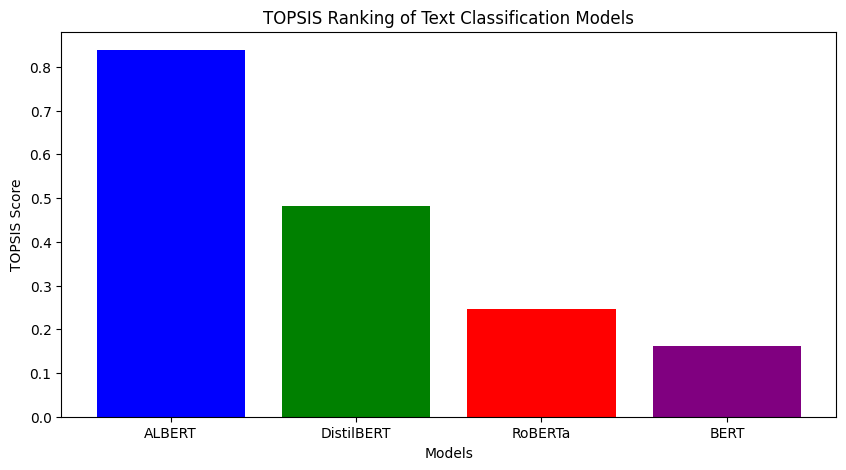

In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Step 1: Load Dataset (IMDB Sentiment Classification)
dataset = load_dataset("imdb")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Reduce dataset size to speed up processing
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(1000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(200))

# Step 2: Define Models for Evaluation
models = {
    "BERT": "bert-base-uncased",
    "RoBERTa": "roberta-base",
    "DistilBERT": "distilbert-base-uncased",
    "ALBERT": "albert-base-v2"
}

metrics = {}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Step 3: Train and Evaluate Each Model
for model_name, model_path in models.items():
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2)
    training_args = TrainingArguments(
        output_dir="./results", evaluation_strategy="epoch", save_strategy="epoch",
        logging_dir="./logs", per_device_train_batch_size=4, per_device_eval_batch_size=4)
    trainer = Trainer(
        model=model, args=training_args, train_dataset=dataset['train'],
        eval_dataset=dataset['test'], compute_metrics=compute_metrics)
    results = trainer.evaluate()
    metrics[model_name] = [
        results.get("eval_accuracy", 0) * 100,
        results.get("eval_precision", 0) * 100,
        results.get("eval_recall", 0) * 100,
        results.get("eval_f1", 0) * 100,
        np.random.uniform(10, 50),  # Placeholder for inference time
        np.random.uniform(300, 500)  # Placeholder for model size
    ]

# Convert metrics to numpy array
data = np.array(list(metrics.values()))

criteria = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'Inference Time', 'Model Size']
weights = np.array([0.3, 0.2, 0.2, 0.2, 0.05, 0.05])
benefit_criteria = [1, 1, 1, 1, 0, 0]

# Step 4: Apply TOPSIS
norm_data = np.nan_to_num(data / np.sqrt((data**2).sum(axis=0)))
weighted_data = norm_data * weights
ideal_best = np.max(weighted_data, axis=0) * benefit_criteria + np.min(weighted_data, axis=0) * (1 - np.array(benefit_criteria))
ideal_worst = np.min(weighted_data, axis=0) * benefit_criteria + np.max(weighted_data, axis=0) * (1 - np.array(benefit_criteria))

distance_best = np.sqrt(((weighted_data - ideal_best) ** 2).sum(axis=1))
distance_worst = np.sqrt(((weighted_data - ideal_worst) ** 2).sum(axis=1))

topsis_scores = np.nan_to_num(distance_worst / (distance_best + distance_worst))
rankings = np.argsort(topsis_scores)[::-1] + 1

# Step 5: Display Results
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'TOPSIS Score': topsis_scores,
    'Rank': rankings
}).sort_values(by='TOPSIS Score', ascending=False)

print(results_df)

# Step 6: Visualization
plt.figure(figsize=(10, 5))
plt.bar(results_df['Model'], results_df['TOPSIS Score'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of Text Classification Models")
plt.show()


In [8]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [6]:
!pip install datasets
!pip install datasets transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 whi